In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [9]:
class LineWorld:
    def __init__(self, nb_cells, start_cell, good_end_cell, bad_end_cell):
        self.done = None
        self.current_state = start_cell  # État actuel
        self.end_good_state = good_end_cell # État final
        self.end_bad_state = bad_end_cell
        self.reward = 0.0
        self.num_states = nb_cells  # Nombre total d'états
        self.states = [i for i in range(nb_cells)]
        self.actions = [0, 1]
        self.num_actions = 2  # Nombre total d'actions possibles
        self.line_world = ["_"] * (self.num_states - 1)
        self.line_world.insert(self.current_state,"X")
        

    def reset(self):
        self.reward = 0.0
        self.done = False
        self.current_state = np.random.randint(1,8)
        
    def isTerminateState(self):
        if (self.current_state == self.end_good_state) or (self.current_state == self.end_bad_state):
            return True
        else:
            return False
        
    def step(self, action):
        # Si l'action est 1, on avance à droite
        if (action == 1):
            self.current_state += 1
            self.reward = -1  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state,"X")
            print(self.line_world)
        # Si l'action est 0, on avance à gauche
        elif (action == 0):
            self.current_state-= 1
            self.reward = -1  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'on atteint l'état final, la partie est terminée
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 1 pour atteindre l'état final
            #print(self.line_world)
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            #print(self.line_world)
            self.done = True
        return self.current_state, self.reward, self.done
        
            

In [10]:
def build_compile_model(env):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(env.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [6]:
def ddqn(env, episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(env)
    target_network = build_compile_model(env)
    nb_steps = 0
    first_episode = True
    
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    batch_size = 32
    memory = deque(maxlen=2000)
    
    for episode in range(episodes):
        env.reset()
        print("Episode : ", episode)
        cumumated_reward = 0
        done = False
        current_state = env.current_state
        while not done:
            actions = env.actions

            q_values = q_network.predict(np.array([current_state]))[0]
            if np.random.rand() < epsilon:
                a = np.random.choice(actions)
            else:
                a= np.argmax(q_values)

            old_reward = env.reward
            new_state, reward, done = env.step(a)
            memory.append((old_reward, a, reward, new_state, done))
            
            """if (len(memory) > batch_size):
                minibatch = random.sample(memory, batch_size)
                for s, ac, reward, ns, terminated in minibatch:"""
            #q_values = q_network.predict(np.array([s]))[0]
            if done:
                q_values[a] = reward
            else:
                t = target_network.predict(np.array([new_state]))[0]
                q_values[a] = reward + gamma * np.amax(t)
            q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
            
            cumumated_reward += reward
            step += 1

            if done:
                target_network.set_weights(q_network.get_weights())
                
        reward_per_episode.append(cumumated_reward)
        print(reward_per_episode)
    return reward_per_episode

Episode :  0
1/1 [==============================] - 0s 71ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 29ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13]
Episode :  1
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3]
Episode :  9
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8]
Episode :  10
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8]
Episode :  11
1/1 [==============================]

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4]
Episode :  21
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_'

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5]
Episode :  30
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6]
Episode :  40
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8]
Episode :  50
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3]
Episode :  67
1/1 [==============================] - 0s 18ms/step
['_', '_

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7]
Episode :  75
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================]

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8]
Episode :  82
1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==========

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8]
Episode :  89
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_',

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3]
Episode :  97
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5]
Episode :  105
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/s

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5]
Episode :  114
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [================

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5]
Episode :  141
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6]
Episode :  147
1/1 [====================

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6]
Episode :  153
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6]

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7]
Episode :  167
1/1 [==============================] - 0s 20ms/step
['_', '_', '_'

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 17ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8]
Episode :  180
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [======================

1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9]
Episode :  193
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_'

Episode :  197
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8]
Episode :  198
1/1 [==============================] - 0s 20ms/step
['_', '_'

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 80ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8]
Episode :  209
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

Episode :  224
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4]
Episode :  250
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5]
Episode :  259
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X',

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7]
Episode :  

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 30ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 28ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['X', '_', '_', '_', 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 29ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 

Episode :  497
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 26ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

Episode :  668
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 28ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

Episode :  677
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 

1/1 [==============================] - 0s 23ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

Episode :  689
1/1 [==============================] - 0s 20ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9,

1/1 [==============================] - 0s 23ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 25ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

Episode :  707
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7

Episode :  710
1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1,

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['X', '_', '_', '_', 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

Episode :  759
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 32ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 22ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 5, 9, 7, 4, -13, -10, 7, 8, 7, 6, 1, 4, 6, 9, 9, -18, -12, -15, -14, -18, -16, -17, -12, 1, -14, -12, -

1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 5, 9, 7, 4, -13, -10, 7, 8, 7, 6, 1, 4, 6, 9, 9, -18, -12, -15, -14, -18, -16, -17, -12, 1, -14, -12, -

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 23ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 22ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 27ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 26ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 25ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 5, 9, 7, 4, -13, -10, 7, 8, 7, 6, 1, 4, 6, 9, 9, -18, -12, -15, -14, -18, -16, -17, -12, 1, -14, -12, -

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 24ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 28ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4, 4, 9, -21, 5, 1, 5, 5, 4, 7, 7, 7, 1, 9, -15, 1, 8, 9, 5, 3, 7, 9, 9, 9, -18, 3, 1, 9, 7, 4, -14, 5, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6,

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9,

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0, 3, 7, 1, 5, 8, 3, 8, 3, 7, 7, 0, -18, -11, 2, 4, 8, 7, 8, 3, 5, 4, 2, -14, 8, 3, 1, -1, 8, 5, 5, 7, 4

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9

1/1 [==============================] - 0s 21ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 23ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 21ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 20ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7,

['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 1, 3, 2, 8, 7, 4, 2, 7, 4, 1, 7, 4, 4, 1, 8, 3, 7, 4, 6, 0, 3, 3, 8, 4, 4, 3, 6, 7, 7, 7, 5, 6, 6, 4, 0

1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
1/1 [==============================] - 0s 22ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 20ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 

1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
1/1 [==============================] - 0s 19ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
1/1 [==============================] - 0s 18ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
[-13, 5, 0, 5, 6, 4, 9, 4, 3, 8, 8, 8, 6, 2, 6, 8, 7, 6, 4, 9, 4, 8, 7, 9, 7, 5, 3, 5, 1, 5, 3, 6, 5, 6, 4, 6, 9, 9, 7, 6, 4, 9, 6, 3, 9, 5, 7, 8, 9, 8, 4, 1, 1, 9, 9, 7, 5, 7, -1, 8, 6, 7, 3, 6, 8, 7, 3, 9, 3, 9, 7, 5, 2, 5, 7, 2, 4, 5, 7, 3, 7, 8, 3, 3, 6, 8, 5, 2, 8, 4, 1, 9, 7, 6, 8, 7, 3, 5, 8, 7, 9, 4, 4, 7, 5, 7, 8, 5, 7, 9, 6, 7, 8, 5, 8, 4, 3, 5, 9, 3, 2, 4, 5, 6, 9, 8, 3, 5, 9, 7, 8, 7, 1, 1, 3, 5, 5, 7, 2, 9, 5, 4, 7, 1, 1, 7, 6, 8, 7, 4, 3, 4, 6, 2, 5, 6, -10, 4, 8, 6, 7, 6, 9, 8, 3, 4, 7, 8, 1, 6, 9, 6, 9, 3, 5, 6, 3, 7, 5, 8, 9, 3, 7, 3, 8, 7, 1, 0, 7, 9, 5, 8, 9, 3, 

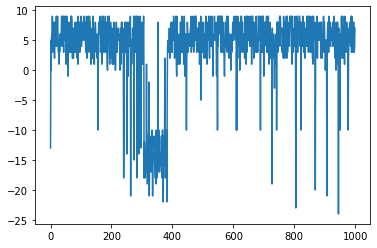

In [11]:
if __name__ == '__main__':
    world = LineWorld(10, 1, 9, 0)
    scores = ddqn(world, episodes = 1000)
    plt.plot(scores)